# LNP Internalization

- Imaging DATE: 2024-11-19

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bioio import BioImage
from scipy import ndimage as ndi
from skimage import io, filters, exposure, segmentation, morphology, measure, feature
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
plt.rcParams.update({
    'font.family': 'Arial',  # Times New Roman, Calibri
    'font.weight': 'normal',
    'mathtext.fontset': 'stixsans',
    'font.size': 18,

    'lines.linewidth': 2,

    'axes.linewidth': 2,
    'axes.spines.top': True,
    'axes.spines.right': True,
    'axes.titleweight': 'bold',
    'axes.titlesize': 18,
    'axes.labelweight': 'bold',

    'xtick.major.size': 8,
    'xtick.major.width': 2,
    'ytick.major.size': 8,
    'ytick.major.width': 2,

    'figure.dpi': 80,
    'savefig.dpi': 80,

    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.fancybox': False,
    'legend.fontsize': 14,

    'animation.html': 'html5',
})

In [3]:
DATE = '2024-11-19'
IMG_DIR = f'/Volumes/TL_SN770_1/img_data/{DATE}'
IMG_FILENAMES = np.array([
    'exp1_PBS.czi', 
    'exp2_LNP_np.czi', 
    'exp3_LNP_APOE.czi',
    'exp4_LNP_VTN.czi', 
    'exp5_LNP_A2M.czi',
    'exp6_LNP_CR.czi', 
    'exp7_PBS.czi', 
    'exp8_LNP_np.czi',
    'exp9_LNP_APOE.czi', 
    'exp10_LNP_VTN.czi', 
    'exp11_LNP_A2M.czi',
    'exp12_LNP_CR.czi', 
    'exp13_PBS.czi', 
    'exp14_LNP_np.czi', 
    'exp15_LNP_APOE.czi',
    'exp16_LNP_VTN.czi',
    'exp17_LNP_A2M.czi', 
    'exp18_LNP_CR.czi', 
    'exp19_APOE.czi',
    'exp20_VTN.czi', 
    'exp21_A2M.czi', 
    'exp22_CR.czi', 
])
LNP_CHANNEL_IDX = 1
LYSOSOME_CHANNEL_IDX = 3
NUCLEUS_CHANNEL_IDX = 5

## Tuning thresholding methods

In [4]:
def get_scene_img(img, scene_idx):
    img.set_scene(scene_idx)
    lazy_t0 = img.get_image_dask_data("CYX")  # returns out-of-memory 4D dask array
    t0 = lazy_t0.compute()  # returns in-memory 4D numpy array
    return t0

In [5]:
# def get_lysosome_mask(img):
#     processed_img = exposure.adjust_log(img, 0.15)
#     threshold = filters.threshold_triangle(processed_img)
#     mask = (processed_img > threshold)
    
#     # post-segmentation image processing
#     mask = morphology.remove_small_objects(mask, 10)
#     mask = morphology.remove_small_holes(mask, 300)
#     mask = morphology.remove_small_objects(mask, 200)
#     mask = ndi.binary_fill_holes(mask)
#     return mask

def get_lysosome_mask(img):
    processed_img = exposure.adjust_log(img, 0.05)
    threshold = filters.threshold_isodata(processed_img)
    mask = (processed_img > threshold)
    
    # post-segmentation image processing
    mask = ndi.binary_fill_holes(mask)
    mask = morphology.remove_small_objects(mask, 5)
    return mask

def get_inner_membrane_mask(mask, n_erosion=10):
    inner_mask = mask.copy()
    for k in range(n_erosion):
        inner_mask = morphology.erosion(inner_mask)
    return inner_mask

def get_inner_outer_membrane_masks(mask, n_erosion=10):
    inner_mask = get_inner_membrane_mask(mask, n_erosion=n_erosion)
    outer_mask = np.bitwise_xor(inner_mask, membrane_mask)
    return inner_mask, outer_mask

def get_nucleus_mask(img):
    # adjust the histogram for image pre-thresholding
    processed_img = exposure.equalize_hist(img)
    
    # segmentation of img by local thresholding on processed_img
    threshold = filters.threshold_local(
        processed_img,
        block_size=35,  # 35
        offset=-10,  # -15 is good for exp 3, -3 is good for exp 1
    )
    mask = (img > threshold)
    
    # post-segmentation image processing
    mask = ndi.binary_fill_holes(mask)
    mask = morphology.remove_small_holes(mask)
    mask = morphology.remove_small_objects(mask, 500)
    for k in range(2):
        mask = morphology.erosion(mask)
    mask = morphology.remove_small_objects(mask, 5000)
    return mask

In [6]:
def remove_uncolocalized_objects(mask1, mask2, verbose=False):
    """
    mask1 contains objects of interest to be removed according to colocalization with mask 2
    Only removes objects that are completely not colocalized. Not based on percentage of colocalization.
    """
    mask1 = mask1.copy()  # avoid data leakage across scope
    mask2 = mask2.copy()  # avoid data leakage across scope
    labeled_mask1 = measure.label(mask1)
    for i in range(1, labeled_mask1.max() + 1):  # zero is background, shift to start from 1
        individual_labeled_mask1 = (labeled_mask1 == i)  # mask of one membrane
        colocalized_mask1 = np.logical_and(individual_labeled_mask1, mask2)  # all zeros if not colocalized
        colocalization_ratio = colocalized_mask1.sum() / individual_labeled_mask1.sum()  # how much is colocalized?
        is_colocalized = bool(colocalization_ratio)
        if verbose:
            print(f'Object = {i}, Colocalization ratio = {colocalization_ratio:.2f}')
        if not is_colocalized:
            mask1[labeled_mask1 == i] = 0  # remove uncolocalized membranes
            if verbose:
                print(f'Removed {i}th object')
    return mask1

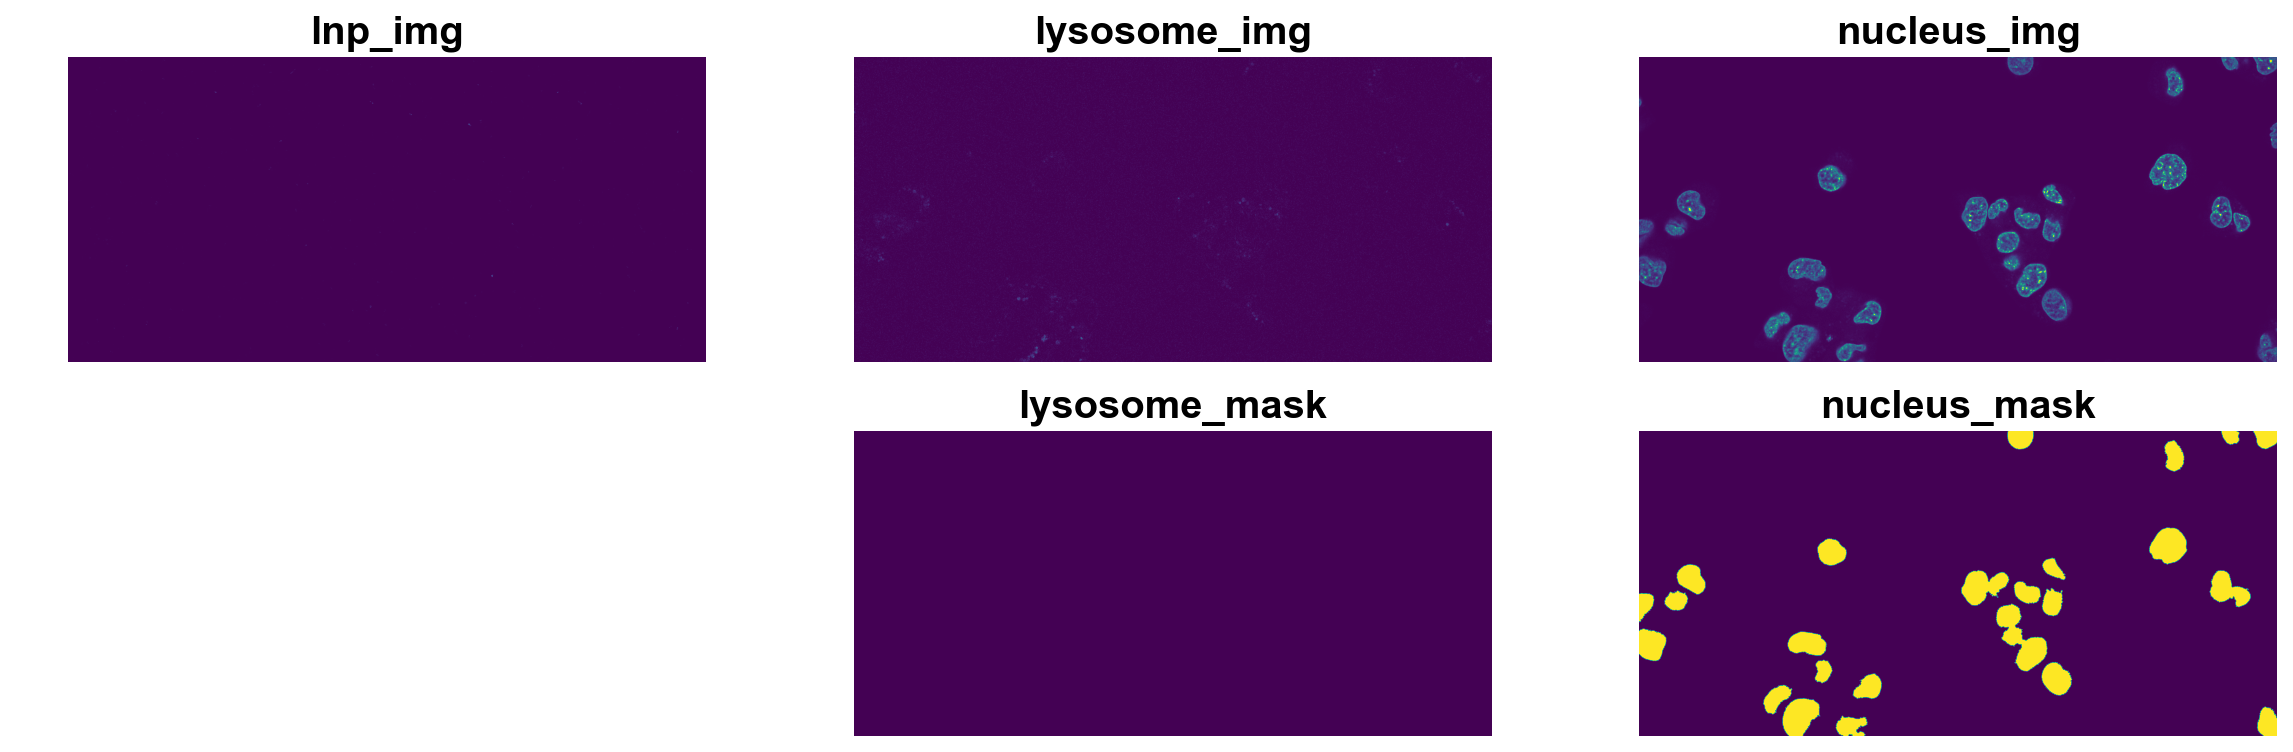

In [7]:
filename_idx = 5
scene_idx = 7

# read the czi image stack
img_filename = os.path.join(IMG_DIR, IMG_FILENAMES[filename_idx])
raw_img = BioImage(img_filename)
img = get_scene_img(raw_img, scene_idx)
lnp_img = img[LNP_CHANNEL_IDX, :, :]
lysosome_img = img[LYSOSOME_CHANNEL_IDX, :, :]
nucleus_img = img[NUCLEUS_CHANNEL_IDX, :, :]

nucleus_mask = get_nucleus_mask(nucleus_img)
lysosome_mask = get_lysosome_mask(lysosome_img)

fig, axs = plt.subplots(2, 3, figsize=(15, 5))
axs[0, 0].imshow(lnp_img)
axs[0, 1].imshow(lysosome_img)
axs[0, 2].imshow(nucleus_img)
# axs[1, 0].imshow(lysosome_mask)
axs[1, 1].imshow(lysosome_mask)
axs[1, 2].imshow(nucleus_mask)

axs[0, 0].set_title('lnp_img')
axs[0, 1].set_title('lysosome_img')
axs[0, 2].set_title('nucleus_img')
# axs[1, 0].set_title('endosome_mask')
axs[1, 1].set_title('lysosome_mask')
axs[1, 2].set_title('nucleus_mask')

for i in range(2):
    for j in range(3):
        axs[i, j].axis('off')
plt.tight_layout()

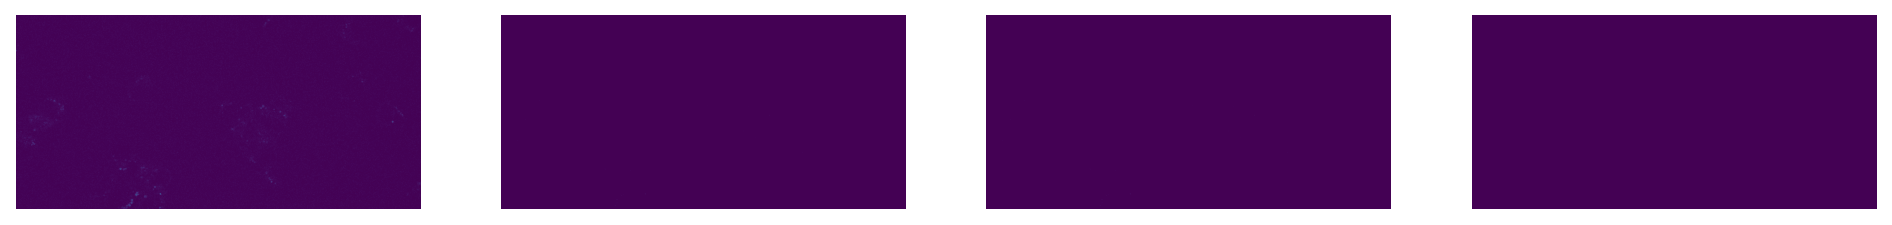

In [8]:
processed_img = exposure.adjust_log(lysosome_img, 0.05)
threshold = filters.threshold_triangle(processed_img)
threshold = filters.threshold_isodata(processed_img)
raw_mask = (processed_img > threshold)

# post-segmentation image processing
# mask = morphology.remove_small_objects(raw_mask, 10)
# mask = morphology.remove_small_holes(mask, 300)
# mask = morphology.remove_small_objects(mask, 200)
mask = ndi.binary_fill_holes(raw_mask)
mask = morphology.remove_small_objects(mask, 5)
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].imshow(lysosome_img)
axs[1].imshow(processed_img)
axs[2].imshow(raw_mask)
axs[3].imshow(mask)
for i in range(4):
    axs[i].set_axis_off()

## Quantifying internalization

In [9]:
def get_object_count(mask):
    return np.unique(measure.label(mask))[-1]

In [10]:
def try_to_numeric(x, errors='raise'):
    try:
        return pd.to_numeric(x, errors=errors)
    except:
        return x

In [11]:
def get_img_in_mask(img, mask):
    masked_img = img.copy()
    masked_img[~mask] = 0
    return masked_img

In [12]:
def save_img(img, img_label):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'{img_label}\n{filename}, S{scene_idx}', fontsize=12)
    fig_filepath = os.path.join(f'processed_img/{DATE}', f'{filename}_s{scene_idx}_{img_label}.png')
    fig.savefig(fig_filepath)
    plt.close()

In [13]:
metadata_name_list = [
    'Filename',
    'Scene ID',
]
property_name_list = [
    'Total LNP intensity in entire img',
    'Total lysosome intensity in entire img',
    'Total nucleus intensity in entire img',
    
    'LNP intensity in nucleus mask',
    'LNP intensity in lysosome mask',
    
    'LNP intensity in lysosome mask per nucleus count',
    
    'Frac LNP intensity in lysosome mask over LNP intensity in nucleus mask',
    'Frac LNP intensity in lysosome mask over total LNP intensity',
    
    'Lysosome mask count',
    'Nucleus count',
]
all_property_name_list = metadata_name_list + property_name_list

In [14]:
SAVE_IMG = True
sample_property_list = []

for j, filename in enumerate(IMG_FILENAMES):
    filepath = os.path.join(IMG_DIR, filename)
    raw_img = BioImage(filepath)
    for scene_idx in range(len(raw_img.scenes)):
        # get image data
        img = get_scene_img(raw_img, scene_idx)
        lnp_img = img[LNP_CHANNEL_IDX, :, :]
        lysosome_img = img[LYSOSOME_CHANNEL_IDX, :, :]
        nucleus_img = img[NUCLEUS_CHANNEL_IDX, :, :]
    
        ## segmentation of membrane and nucleus
        nucleus_mask = get_nucleus_mask(nucleus_img)
        lysosome_mask = get_lysosome_mask(lysosome_img)

        ## masked LNP image
        lnp_in_nucleus_img = get_img_in_mask(lnp_img, nucleus_mask)
        lnp_in_lysosome_img = get_img_in_mask(lnp_img, lysosome_mask)

        # calculate intensities
        lnp_intensity = lnp_img.sum()
        lysosome_intensity = lysosome_img.sum()
        nucleus_intensity = nucleus_img.sum()
        lnp_in_nucleus_intensity = lnp_in_nucleus_img.sum()
        lnp_in_lysosome_intensity = lnp_in_lysosome_img.sum()

        # calculate object counts
        lysosome_count = get_object_count(lysosome_mask)
        nucleus_count = get_object_count(nucleus_mask)

        sample_property_list.append([
            # meta data
            filename, 
            scene_idx,

            # total intensity in each channel
            lnp_intensity,
            lysosome_intensity,
            nucleus_intensity,

            # lnp intensity in mask
            lnp_in_nucleus_intensity,
            lnp_in_lysosome_intensity,

            # lnp intensity in mask per boundary number
            lnp_in_lysosome_intensity / nucleus_count,

            # fraction of lnp intensity in mask vs total lnp intensity
            lnp_in_lysosome_intensity / lnp_in_nucleus_intensity,
            lnp_in_lysosome_intensity / lnp_intensity,
            
            # object count
            lysosome_count,
            nucleus_count,
        ])

        if SAVE_IMG:
            save_img(lnp_img, 'lnp_img')
            save_img(nucleus_img, 'nucleus_img')
            save_img(lysosome_img, 'lysosome_img')
            
            save_img(lysosome_mask, 'lysosome_mask')
            save_img(nucleus_mask, 'nucleus_mask')
            
            save_img(lnp_in_lysosome_img, 'lnp_in_lysosome_img')
            save_img(lnp_in_nucleus_img, 'lnp_in_nucleus_img')

/var/folders/xw/swxm3b951rq22wf0cr61c7vm0000gn/T/ipykernel_10115/767626870.py:48: RuntimeWarning: invalid value encountered in divide
  lnp_in_lysosome_intensity / nucleus_count,
/var/folders/xw/swxm3b951rq22wf0cr61c7vm0000gn/T/ipykernel_10115/767626870.py:51: RuntimeWarning: invalid value encountered in scalar divide
  lnp_in_lysosome_intensity / lnp_in_nucleus_intensity,
/var/folders/xw/swxm3b951rq22wf0cr61c7vm0000gn/T/ipykernel_10115/767626870.py:48: RuntimeWarning: invalid value encountered in divide
  lnp_in_lysosome_intensity / nucleus_count,
/var/folders/xw/swxm3b951rq22wf0cr61c7vm0000gn/T/ipykernel_10115/767626870.py:51: RuntimeWarning: invalid value encountered in scalar divide
  lnp_in_lysosome_intensity / lnp_in_nucleus_intensity,
/var/folders/xw/swxm3b951rq22wf0cr61c7vm0000gn/T/ipykernel_10115/767626870.py:48: RuntimeWarning: invalid value encountered in divide
  lnp_in_lysosome_intensity / nucleus_count,
/var/folders/xw/swxm3b951rq22wf0cr61c7vm0000gn/T/ipykernel_10115/7676

In [17]:
properties_df = pd.DataFrame(np.array(sample_property_list))
properties_df.columns = all_property_name_list
properties_df.iloc[:, 1:] = properties_df.iloc[:, 1:].apply(try_to_numeric, **dict(errors='coerce'))
properties_df = properties_df.apply(try_to_numeric)
properties_df

,Filename,Scene ID,Total LNP intensity in entire img,Total lysosome intensity in entire img,Total nucleus intensity in entire img,LNP intensity in nucleus mask,LNP intensity in lysosome mask,LNP intensity in lysosome mask per nucleus count,Frac LNP intensity in lysosome mask over LNP intensity in nucleus mask,Frac LNP intensity in lysosome mask over total LNP intensity,Lysosome mask count,Nucleus count
0,exp1_PBS.czi,0,50367,5413335,30020169,9623,727,30.291667,0.075548,0.014434,200,24
1,exp1_PBS.czi,1,41282,4565897,22273917,5019,522,34.800000,0.104005,0.012645,174,15
2,exp1_PBS.czi,2,84436,9396528,29902105,8585,3315,103.593750,0.386139,0.039261,827,32
3,exp1_PBS.czi,3,43788,3528369,8922213,6459,402,36.545455,0.062239,0.009181,107,11
4,exp1_PBS.czi,4,71380,8234937,35963132,9691,2306,79.517241,0.237953,0.032306,541,29
...,...,...,...,...,...,...,...,...,...,...,...,...
259,exp22_CR.czi,7,86243,6476564,30713061,10775,670,37.222222,0.062181,0.007769,206,18
260,exp22_CR.czi,8,65660,4140707,10441783,4539,241,30.125000,0.053095,0.003670,98,8
261,exp22_CR.czi,9,49985,4805401,20668484,5100,161,14.636364,0.031569,0.003221,65,11
262,exp22_CR.czi,10,81032,9370412,52290657,12818,1044,33.677419,0.081448,0.012884,626,31


In [18]:
properties_df_filename = os.path.join(f'processed_data/{DATE}', f"properties_df.csv")
properties_df.to_csv(properties_df_filename)

### Filter for membrane and nucleus count

In [52]:
filtered_df = properties_df[(properties_df['Nucleus count'] >= 5)]
# filtered_df = properties_df.copy()

In [53]:
filtered_df_filename = os.path.join(f'processed_data/{DATE}', f"filtered_df.csv")
filtered_df.to_csv(filtered_df_filename)

### Transform dataframe for GraphPad Prism by scene

In [54]:
max_sample_size = filtered_df['Scene ID'].max() + 1
exp_group_size = len(IMG_FILENAMES)

In [55]:
property_array = np.zeros((max_sample_size, exp_group_size))
property_array.fill(np.nan)
property_array

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, 

In [56]:
exp_prop_list = []
for property_name in property_name_list:
    for exp_i, filename in enumerate(IMG_FILENAMES):
        data = filtered_df.loc[filtered_df['Filename'] == filename, property_name].values
        sample_size = len(data)
        property_array[:sample_size, exp_i] = data
        property_array_filename = os.path.join(f'processed_data/{DATE}/scene', f'{property_name}.csv')
        np.savetxt(property_array_filename, property_array, delimiter=",")

In [57]:
pd.Series(IMG_FILENAMES).to_csv(f'processed_data/{DATE}/exp_groups.csv')

### Transform dataframe for GraphPad Prism by technical replicates

Each experiment has 4 technical replicates, grouped by 3 scenes.

In [49]:
# num_scene = 3
# num_tech_rep = 4

In [88]:
filtered_df.loc[:, 'Technical replicate ID'] = filtered_df.loc[:, 'Scene ID']
for i in range(4):
    filtered_df.loc[filtered_df['Technical replicate ID'].isin(np.arange(3 * i, 3 * i + 3)), 'Technical replicate ID'] = i + 1
filtered_df_tech = filtered_df.groupby(['Filename', 'Technical replicate ID']).mean().reset_index()
filtered_df_tech.head()

,Filename,Technical replicate ID,Scene ID,Total LNP intensity in entire img,Total lysosome intensity in entire img,Total nucleus intensity in entire img,LNP intensity in nucleus mask,LNP intensity in lysosome mask,LNP intensity in lysosome mask per nucleus count,Frac LNP intensity in lysosome mask over LNP intensity in nucleus mask,Frac LNP intensity in lysosome mask over total LNP intensity,Lysosome mask count,Nucleus count
0,exp10_LNP_VTN.czi,1,0.5,1601587.0,4.594053e+06,1.138156e+07,77382.5,13589.500000,1461.477778,0.424693,0.008531,139.000000,9.5
1,exp10_LNP_VTN.czi,2,3.5,1427490.0,5.284116e+06,1.720140e+07,28257.0,10349.500000,741.491667,0.397780,0.007129,188.500000,13.5
2,exp10_LNP_VTN.czi,3,6.0,1435066.0,4.966453e+06,1.155829e+07,37760.0,8894.000000,889.400000,0.235540,0.006198,153.000000,10.0
3,exp10_LNP_VTN.czi,4,9.5,1506654.0,3.742628e+06,7.135778e+06,39795.0,3650.500000,398.200000,0.159094,0.002826,52.000000,7.5
4,exp11_LNP_A2M.czi,1,1.0,874038.0,4.094431e+06,9.843879e+06,19839.0,1242.666667,119.929345,0.068846,0.001523,90.666667,9.0


In [89]:
# tech_rep_idx_list = np.array(
#     list(np.array([[i] * num_scene for i in range(1, num_tech_rep+1)]).reshape(-1)) * exp_group_size
#     # + list(np.array([[i] * num_scene for i in range(5, 5+num_tech_rep)]).reshape(-1))
# )
# filtered_df['Technical replicate ID'] = tech_rep_idx_list
# filtered_df_tech = filtered_df.groupby(['Filename', 'Technical replicate ID']).mean().reset_index()
# filtered_df_tech.head()

In [90]:
property_array = np.zeros((num_tech_rep, exp_group_size))
property_array.fill(np.nan)
property_array

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan]])

In [91]:
exp_prop_list = []
for property_name in property_name_list:
    for exp_i, filename in enumerate(IMG_FILENAMES):
        data = filtered_df_tech.loc[filtered_df_tech['Filename'] == filename, property_name].values
        sample_size = len(data)
        property_array[:sample_size, exp_i] = data
        property_array_filename = os.path.join(f'processed_data/{DATE}/tech_rep', f'{property_name}.csv')
        np.savetxt(property_array_filename, property_array, delimiter=",")